In [2]:
#Yassin TALSSIS
#Meriem ENNOURI
import torch
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


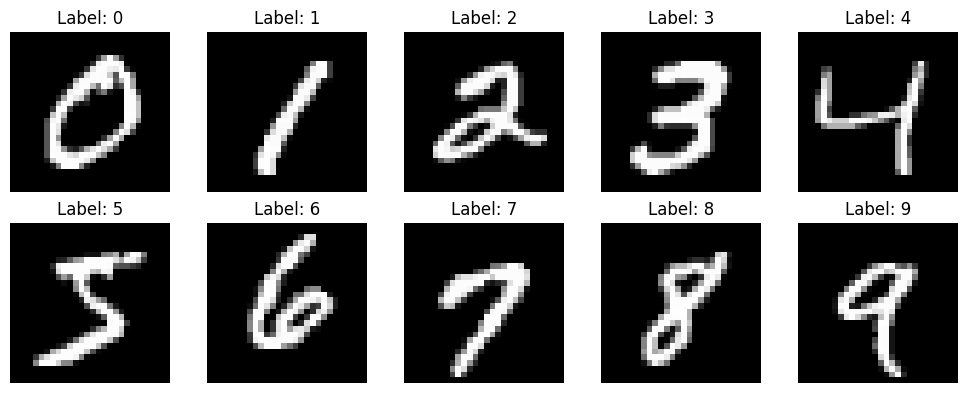

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    for j in range(len(y)):
             if(y[j]==i):
                ax.imshow(X.values[j].reshape(28, 28), cmap='gray')
                ax.set_title("Label: {}".format(y[j]))
                ax.axis('off')
                break
                    
plt.tight_layout()
plt.show()

# K-NN with CPU

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert data into PyTorch tensors
X_train = torch.from_numpy(X_train.values)
y_train = torch.from_numpy(y_train.values)
X_test = torch.from_numpy(X_test.values)

# Define the number of neighbors to consider
k = 5

# Function to compute distances between images
def compute_distances(X_train, X_test):
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    dists = torch.zeros((n_test, n_train))
    for i in range(n_test):
        dists[i, :] = torch.sqrt(torch.sum((X_test[i, :] - X_train) ** 2, dim=1))
    return dists

# Function to predict class labels for test images
def predict_labels(dists, y_train, k):
    num_test = dists.shape[0]  # Get the number of test samples
    y_pred = torch.zeros(num_test, dtype=torch.int64)  # Initialize the predicted labels tensor
    for i in range(num_test):  # Iterate over each test sample
        _, indices = torch.topk(dists[i, :], k, largest=False)  # Find the indices of the k nearest neighbors
        k_nearest_labels = y_train[indices]  # Get the labels of the k nearest neighbors
        unique_labels, counts = torch.unique(k_nearest_labels, return_counts=True)  # Count the occurrences of each unique label
        y_pred[i] = unique_labels[torch.argmax(counts)]  # Assign the label with the highest count as the predicted label for the test sample
    return y_pred


start_time = time.time()
# Compute distances and predict class labels for test images
dists = compute_distances(X_train, X_test)
y_pred = predict_labels(dists, y_train, k)

end_time = time.time()

# Convert predictions to NumPy arrays and evaluate model accuracy
y_pred_np = y_pred.numpy()
y_test_np = y_test.values.astype(np.float32)
accuracy = accuracy_score(y_test_np, y_pred_np)
print("Accuracy:", accuracy)
print("Total computing time: %.2f seconds" % (end_time - start_time))

# K-NN with GPU

In [23]:
# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert data into ndarrays and move to GPU
X_train = torch.from_numpy(X_train.values).to(device)
y_train = torch.from_numpy(y_train.values).to(device)
X_test = torch.from_numpy(X_test.values).to(device)

# Define the number of neighbors to consider
k = 5

# Function to compute distances between images
def compute_distances(X_train, X_test):
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    dists = torch.zeros((n_test, n_train), device=device)
    for i in range(n_test):
        dists[i, :] = torch.sqrt(torch.sum((X_test[i, :] - X_train) ** 2, dim=1)).to(device)
    return dists

# Function to predict class labels for test images
def predict_labels(dists, y_train, k):
    num_test = dists.shape[0]  # Get the number of test samples
    y_pred = torch.zeros(num_test, dtype=torch.int64)  # Initialize the predicted labels tensor
    for i in range(num_test):  # Iterate over each test sample
        _, indices = torch.topk(dists[i, :], k, largest=False)  # Find the indices of the k nearest neighbors
        k_nearest_labels = y_train[indices]  # Get the labels of the k nearest neighbors
        unique_labels, counts = torch.unique(k_nearest_labels, return_counts=True)  # Count the occurrences of each unique label
        y_pred[i] = unique_labels[torch.argmax(counts)].to(device) # Assign the label with the highest count as the predicted label for the test sample
    return y_pred

start_time = time.time()
# Compute distances and predict class labels for test images
dists = compute_distances(X_train, X_test)
y_pred = predict_labels(dists, y_train, k)

end_time = time.time()
# Move predictions and ground truth labels to CPU for evaluation
y_pred_np = y_pred.to('cpu').numpy()
y_test_np = y_test.values.astype(np.float32)

# Calculate accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print("Accuracy:", accuracy)
print("Total computing time: %.2f seconds" % (end_time - start_time))

Accuracy: 0.9734285714285714
Total computing time: 27.25 seconds
